In [1]:
from ib_insync import *
import pandas as pd
import ib_connection as IBC
import numpy as np
import scipy.sparse as sp
import big_graphs as BG
from Records import Records
from pathlib import Path
import graph_signal as GS

util.startLoop()
ibc, ib = IBC.quick_connect(2)

positions request timed out


In [2]:
r = Records()
r.tickers = IBC.show_universe("SP500_filtered")
r.dur = "8 Y"
r.size = "1 day"
r.t = 252
r.long_window = 252
r.short_window = 60
r.window = 252

r.fetch_comp(ib, progress=False)
r.mkt_tickers = ["SPY"]
r.fetch_mkt(ib, progress=False)
r.set_all()

===== Running universe: SP500_filtered (463 names) =====
Universe:SP500_filtered
Description : 
  SP500 filtered: tickers with >= 2000 valid dates (non-NaN prices)
Tickers (463):
  MMM, AOS, ABT, ABBV, ACN, ADBE, AMD, AES, AFL, A, APD, AKAM, ALB, ARE, ALGN, ALLE, LNT, ALL, GOOGL, GOOG, MO, AMZN, AEE, AEP, AXP, AIG, AMT, AWK, AMP, AME, AMGN, APH, ADI, AON, APA, APO, AAPL, AMAT, APTV, ACGL, ADM, ARES, ANET, AJG, AIZ, T, ATO, ADSK, ADP, AZO, AVB, AVY, AXON, BKR, BALL, BAC, BAX, BDX, BBY, TECH, BIIB, BLK, BX, XYZ, BK, BA, BKNG, BSX, BMY, AVGO, BR, BRO, BLDR, BG, BXP, CHRW, CDNS, CPT, CPB, COF, CAH, CCL, CVNA, CAT, CBOE, CBRE, CDW, COR, CNC, CNP, CF, CRL, SCHW, CHTR, CVX, CMG, CB, CHD, CI, CINF, CTAS, CSCO, C, CFG, CLX, CME, CMS, KO, CTSH, CL, CMCSA, FIX, CAG, COP, ED, STZ, CPRT, GLW, CPAY, CSGP, COST, CTRA, CCI, CSX, CMI, CVS, DHR, DRI, DVA, DECK, DE, DAL, DVN, DXCM, FANG, DLR, DG, DLTR, D, DPZ, DOV, DHI, DTE, DUK, DD, ETN, EBAY, ECL, EIX, EW, EA, ELV, EME, EMR, ETR, EOG, EPAM, EQT, EFX, E

In [3]:
W_sym_by_date = GS.get_W_sym_by_date(r,"SPY")

[cache] HIT  path=cache\graphs\5924ce5893e299948426816030fe9753.pkl load_sec=0.139 at=2026-01-04 22:14:11


In [5]:
signal_df = GS.W_to_signal(
    r=r,
    E=r.static_resid["SPY"],
    W_by_date=W_sym_by_date,
    clip_eps=None,
)
trading_days = r.get_trading_days()

signal_df = signal_df.reindex(index=trading_days, columns=r.companies).fillna(0.0)

signal_z = signal_df.sub(signal_df.mean(axis=1), axis=0).div(signal_df.std(axis=1), axis=0)
signal_z = signal_z.replace([np.inf, -np.inf], np.nan).fillna(0.0)

sharpe_gross =  0.08035680932207953
sharpe_net =  -0.25525611202105625
mean turnover: 1.3817185449007836
cost.sum() =  0.24166257350314702
equity_net.iloc[-1] =  0.8015714583398322


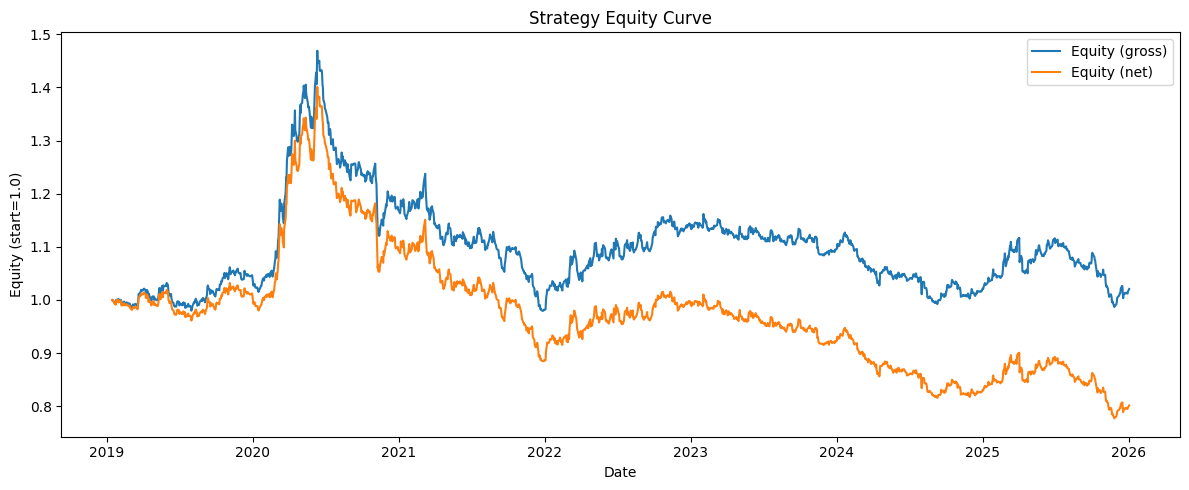

In [6]:
import residual_signal as RS

equity_gross, equity_net = r.pnl_trading(RS.L1_regularization(signal_z), tc_bps=1.0)
BG.plot_equity(equity_gross, equity_net, title="Strategy Equity Curve")

In [15]:
signal_spec = GS.spectral_truncated_signal(r, W_sym_by_date, r.static_resid["SPY"], k=10)

missing spectral W on trading_days: 0


In [21]:
trading_days = r.get_trading_days()

signal_spec = signal_spec.reindex(index=trading_days, columns=r.companies).fillna(0.0)

# Cross-sectional z-score to put the spectral signal on a comparable scale.
signal_spec = RS.L1_regularization(signal_spec)

weight_spec = RS.extreme_signal_to_weights(r, -signal_spec, signal_spec)


active_ratio =  0.0


sharpe_gross =  nan
sharpe_net =  nan
mean turnover: 0.0
cost.sum() =  0.0
equity_net.iloc[-1] =  1.0


h:\Personal Projects\QuantPlayground\Records.py:542: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_gross = (pnl.mean() / pnl.std()) * (ann_factor ** 0.5)
h:\Personal Projects\QuantPlayground\Records.py:543: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_net = (pnl_net.mean() / pnl_net.std()) * (ann_factor ** 0.5)


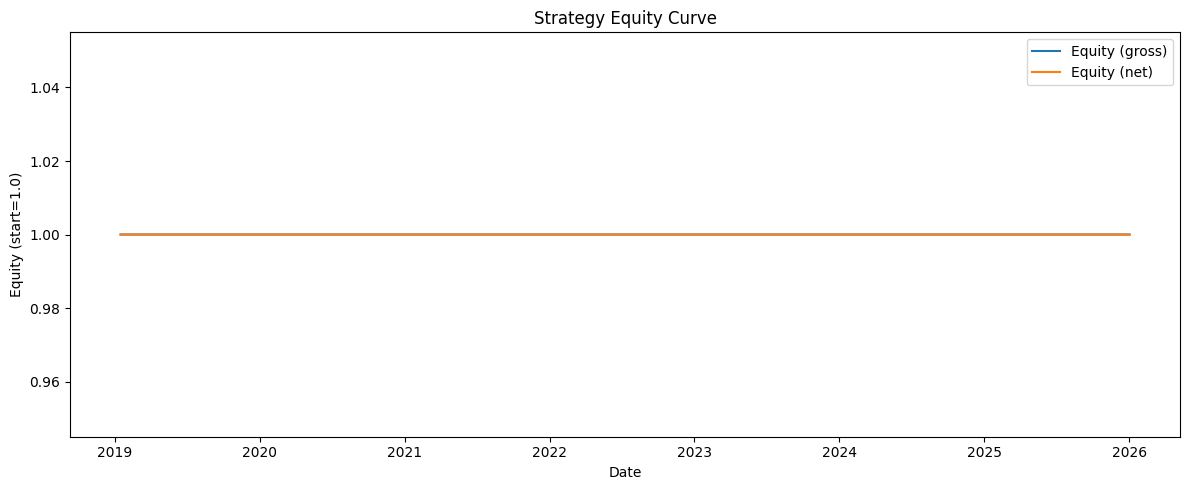

In [22]:
equity_gross, equity_net = r.pnl_trading(signal_spec, tc_bps=1.0)
BG.plot_equity(equity_gross, equity_net, title="Strategy Equity Curve")

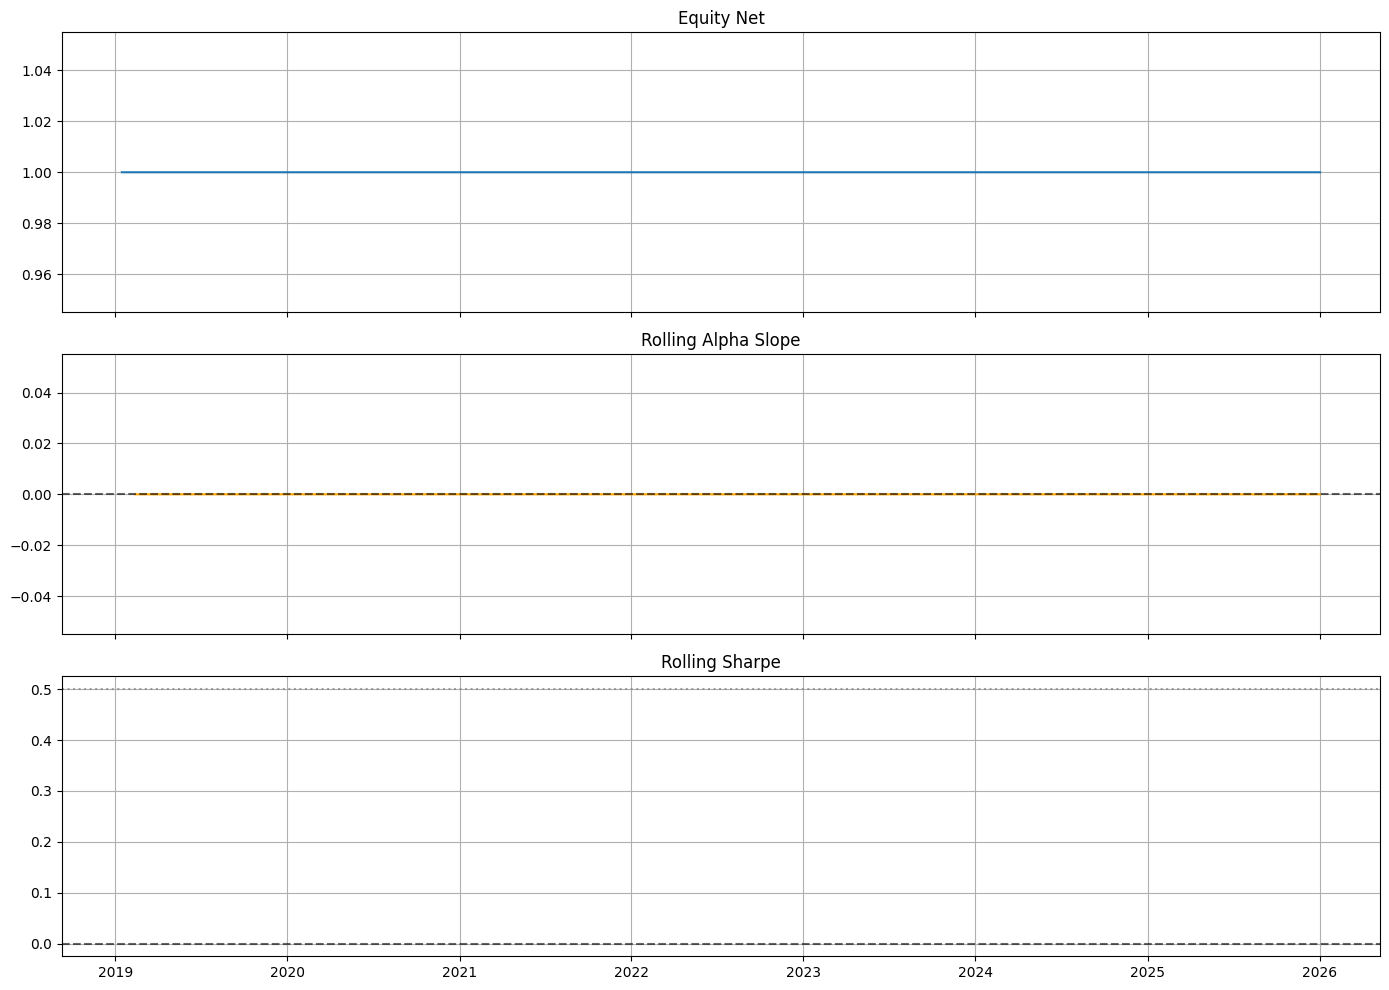

In [9]:
BG.plot_alpha_diff_diagnostics(equity_net,W=20)